# Fine-Tuning on a Pre-Trained Model

There is no need to train what someone else has trained before. We need to have mercy with our mother Earth (the computation keeps warming it up)! The knowledge about lanugage transfers from task to task, so we can re-use the big pre-trained models on our specific tasks. This process is reffered to as fine-tuning, before which the model has been pre-trained for on some general task. In this notebook, we go through an example on how to do that.

This notebook has been adapted from [here](https://github.com/GaneshLokare/Transformers/blob/main/Fine%20Tuning%20Transformers%20with%20custom%20dataset%20Classification%20task.ipynb).

# Preparation
Let's install dependencies and import them, this does not include all of them.

In [1]:
# !pip install transformers
# !pip install datasets
# !pip install torchinfo
# !pip install accelerate
# !pip install scikit-learn
# !pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from torchinfo import summary

/home/michal/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-21 10:29:03.770376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset
First we download the dataset from the website. If the link does not work for you, you can download it manually by going [here](https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv).

In [3]:
!wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

File ‘AirlineTweets.csv?dl=0’ already there; not retrieving.



Now we can load the dataset and look what is in it. The dataset contains tweets about airlines, which the airline is interested in classifying as positive, negative and neutral. We will make a classifier for that.

In [4]:
df = pd.read_csv('AirlineTweets.csv?dl=0')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Now we map the targets to numbers, rename columns, save as csv.

In [5]:
df = df[['airline_sentiment','text']].head(1000) # to shorten the training time
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2} # define mapping of classes
df['target'] = df['airline_sentiment'].map(target_map) # map the classes to integers
df1 = df[['text','target']] # select only the text and target columns
df1.columns = ['sentence','label'] # rename the columns to sentence and label
df1.to_csv('data.csv', index = False) # save the data to a csv file

To use the dataset with the pre-trained model, we need to take make it a dataset object. This gives us some additional functionality, such as splitting the dataset into train and test split.

In [6]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=107)
split

Generating train split: 1000 examples [00:00, 165039.11 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 700
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 300
    })
})

# Tokenization

We use the BERT tokenizer to tokenize the text data. It is important to use the same tokenizer that was used to train the pre-trained model. This is because the tokenizer has a specific vocabulary and the tokenization process is not just splitting the text into words. The tokenizer also adds special tokens, converts the tokens to ids, and pads the sequences to a fixed length.

In [7]:
tokernizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [8]:
tokenized_dataset = split.map(lambda batch: tokernizer(
    batch['sentence'], truncation=True), batched=True)

Map: 100%|██████████| 300/300 [00:00<00:00, 27342.86 examples/s]


In [9]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 700
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [10]:
tokenized_dataset['train'][0]

{'sentence': "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 'label': 1,
 'input_ids': [101,
  137,
  6567,
  1592,
  4027,
  4578,
  1573,
  7215,
  1111,
  1139,
  1148,
  2771,
  1583,
  3043,
  10722,
  3190,
  1106,
  12029,
  2346,
  146,
  112,
  1396,
  1767,
  1720,
  1133,
  1632,
  1614,
  1164,
  6567,
  1738,
  119,
  108,
  1853,
  2137,
  22979,
  1942,
  1186,
  2349,
  1186,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

# Classification Model Training

We will use the `Trainer` class from the `transformers` library to train the model. The `Trainer` class takes care of the training loop, logging, and evaluation. We need to provide the model, training arguments, and the training and evaluation datasets to the `Trainer` class.

The model that we are going to use is made for sequence classification, and we specify the number of target labels to be 3.

In [11]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
summary(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/michal/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

We need to define the training arguments. We can specify the output directory where the model checkpoints will be saved, the number of training epochs, the batch size, and the evaluation strategy. The output directory is where we will find our finished, trained model.

In [12]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=4,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

/home/michal/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


We can also specify the evaluation metric(s) that we want to use to evaluate the model. We can define a function that takes the logits (predictions) and labels as input and returns the evaluation metric. In this case, we will use the accuracy and F1 score as evaluation metrics.

In [13]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels  # unpack the logits and labels
    predictions = np.argmax(logits, axis=-1)  # get the predicted class
    acc = np.mean(predictions == labels)  # compute the accuracy
    f1 = f1_score(labels, predictions, average='micro')  # compute the f1 score
    return {'accuracy': acc, 'f1_score': f1}  # return the metrics

In [14]:
trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_dataset["train"],
                  eval_dataset=tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

/home/michal/.local/lib/python3.8/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [15]:
trainer.train()

                                                
 25%|██▌       | 44/176 [01:37<04:06,  1.87s/it]Checkpoint destination directory training_dir/checkpoint-44 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6466067433357239, 'eval_accuracy': 0.76, 'eval_f1_score': 0.76, 'eval_runtime': 12.2215, 'eval_samples_per_second': 24.547, 'eval_steps_per_second': 0.409, 'epoch': 1.0}


                                                
 50%|█████     | 88/176 [03:25<02:51,  1.95s/it]Checkpoint destination directory training_dir/checkpoint-88 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6119727492332458, 'eval_accuracy': 0.7533333333333333, 'eval_f1_score': 0.7533333333333333, 'eval_runtime': 12.0251, 'eval_samples_per_second': 24.948, 'eval_steps_per_second': 0.416, 'epoch': 2.0}


                                                 
 75%|███████▌  | 132/176 [05:08<01:20,  1.82s/it]Checkpoint destination directory training_dir/checkpoint-132 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.8365830779075623, 'eval_accuracy': 0.77, 'eval_f1_score': 0.7699999999999999, 'eval_runtime': 10.7984, 'eval_samples_per_second': 27.782, 'eval_steps_per_second': 0.463, 'epoch': 3.0}


                                                 
100%|██████████| 176/176 [06:57<00:00,  1.93s/it]

{'eval_loss': 0.8867305517196655, 'eval_accuracy': 0.7633333333333333, 'eval_f1_score': 0.7633333333333333, 'eval_runtime': 13.4328, 'eval_samples_per_second': 22.333, 'eval_steps_per_second': 0.372, 'epoch': 4.0}


100%|██████████| 176/176 [06:58<00:00,  2.38s/it]

{'train_runtime': 418.5271, 'train_samples_per_second': 6.69, 'train_steps_per_second': 0.421, 'train_loss': 0.3544901067560369, 'epoch': 4.0}


TrainOutput(global_step=176, training_loss=0.3544901067560369, metrics={'train_runtime': 418.5271, 'train_samples_per_second': 6.69, 'train_steps_per_second': 0.421, 'train_loss': 0.3544901067560369, 'epoch': 4.0})

# Evaluation

We load the saved model (in this case checkpoint 132) and use it to make predictions on the test dataset. We can then evaluate the model using the accuracy and F1 score, and confusion matrix.

In [16]:
saved_model = pipeline('text-classification', model = 'training_dir/checkpoint-132') # load the saved model, mind the checkpoint number

In [17]:
prediction = saved_model(split['test']['sentence'])
prediction[:5]

[{'label': 'LABEL_0', 'score': 0.6078603863716125},
 {'label': 'LABEL_2', 'score': 0.977277934551239},
 {'label': 'LABEL_0', 'score': 0.9855540990829468},
 {'label': 'LABEL_1', 'score': 0.9874082803726196},
 {'label': 'LABEL_2', 'score': 0.8189789652824402}]

In [18]:
extracted_predictions = [int(d['label'].split('_')[1]) for d in prediction] # extract the predicted labels

In [19]:
print("acc:", accuracy_score(split['test']['label'], extracted_predictions))
print("f1:", f1_score(split['test']['label'], extracted_predictions, average='macro'))

acc: 0.77
f1: 0.7436117209650215


Of course, plotting the confusion matrix is an important part of evaluating the model.

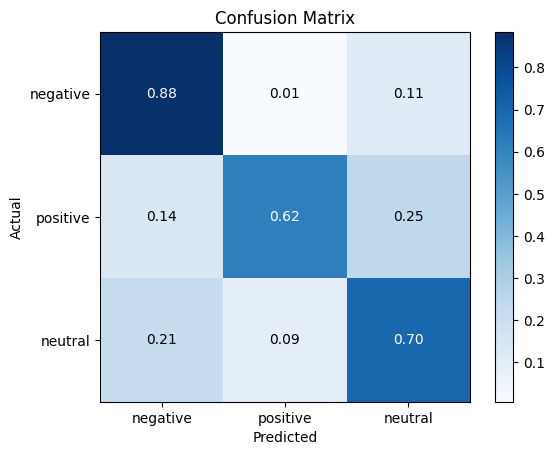

In [20]:
def plot_cm(cm):
    classes = ['negative', 'positive', 'neutral']
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='Actual',
           xlabel='Predicted')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()
    
cm = confusion_matrix(split['test']['label'],extracted_predictions, normalize = 'true')
plot_cm(cm)